In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask-detection/face_mask_detection/Training_set_face_mask.csv
/kaggle/input/face-mask-detection/face_mask_detection/Testing_set_face_mask.csv
/kaggle/input/face-mask-detection/face_mask_detection/Image conversion.ipynb
/kaggle/input/face-mask-detection/face_mask_detection/train/Without_Mask/Image_453.jpg
/kaggle/input/face-mask-detection/face_mask_detection/train/Without_Mask/Image_4604.jpg
/kaggle/input/face-mask-detection/face_mask_detection/train/Without_Mask/Image_4240.jpg
/kaggle/input/face-mask-detection/face_mask_detection/train/Without_Mask/Image_25.jpg
/kaggle/input/face-mask-detection/face_mask_detection/train/Without_Mask/Image_2587.jpg
/kaggle/input/face-mask-detection/face_mask_detection/train/Without_Mask/Image_812.jpg
/kaggle/input/face-mask-detection/face_mask_detection/train/Without_Mask/Image_1626.jpg
/kaggle/input/face-mask-detection/face_mask_detection/train/Without_Mask/Image_210.jpg
/kaggle/input/face-mask-detection/face_mask_detection/train/Wit

## Display Few Images

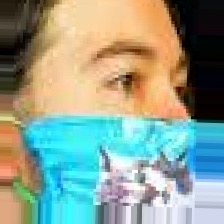

In [2]:
#viewing any image from the train data.
from IPython.display import Image
Image('../input/face-mask-detection/face_mask_detection/train/With_Mask/Image_10002.jpg')

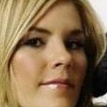

In [3]:
Image('../input/face-mask-detection/face_mask_detection/train/Without_Mask/Image_1002.jpg')

## Import the required packages

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.applications import vgg16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(7)

In [5]:
train_path = '../input/face-mask-detection/face_mask_detection/train'
test_path = '../input/face-mask-detection/face_mask_detection/test'

## Read the images

In [6]:
train_datagen = ImageDataGenerator(validation_split = 0.2,
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 classes = ['With_Mask', 'Without_Mask'],
                                                 subset = 'training')

val_set = train_datagen.flow_from_directory(train_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            classes = ['With_Mask', 'Without_Mask'],
                                            subset = 'validation')

Found 9012 images belonging to 2 classes.
Found 2252 images belonging to 2 classes.


In [7]:
imgs, labels = next(training_set)

In [8]:
print(imgs.shape)
print(labels.shape)

(32, 224, 224, 3)
(32, 2)


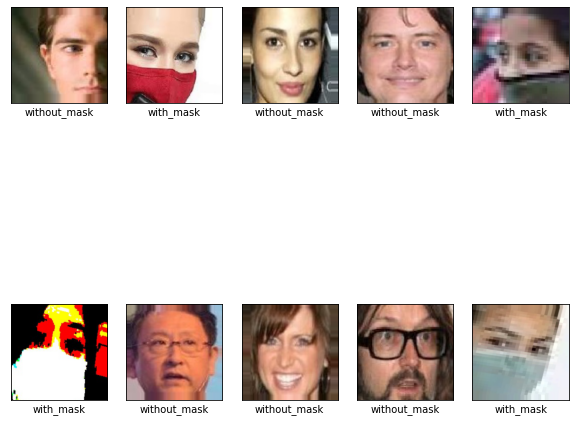

In [9]:
# code to view the images
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid=False
    plt.imshow(imgs[i])
    if labels[i][1] == 1.0:
        plt.xlabel('without_mask')
    else:
        plt.xlabel('with_mask')
plt.show()

## Build the VGG16 model

In [10]:
vgg = vgg16.VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [11]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [13]:
model = Sequential()
for layer in vgg.layers:
    model.add(layer)

In [14]:
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

#### Compile the model

In [16]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [17]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=3)

#### Fit the model

In [18]:
# fit the model
r = model.fit_generator(
    training_set,
    validation_data=val_set,
    epochs=10,
    steps_per_epoch=len(training_set),
    validation_steps=len(val_set),
    callbacks=[es]
)

Epoch 1/10
282/282 [==============================] - 182s 644ms/step - loss: 0.1624 - accuracy: 0.9523 - val_loss: 0.0773 - val_accuracy: 0.9836
Epoch 2/10
282/282 [==============================] - 165s 586ms/step - loss: 0.0649 - accuracy: 0.9835 - val_loss: 0.0584 - val_accuracy: 0.9827
Epoch 3/10
282/282 [==============================] - 165s 584ms/step - loss: 0.0462 - accuracy: 0.9886 - val_loss: 0.0480 - val_accuracy: 0.9836
Epoch 4/10
282/282 [==============================] - 165s 586ms/step - loss: 0.0371 - accuracy: 0.9909 - val_loss: 0.0413 - val_accuracy: 0.9902
Epoch 5/10
282/282 [==============================] - 164s 583ms/step - loss: 0.0340 - accuracy: 0.9908 - val_loss: 0.0335 - val_accuracy: 0.9889
Epoch 6/10
282/282 [==============================] - 163s 578ms/step - loss: 0.0281 - accuracy: 0.9920 - val_loss: 0.0321 - val_accuracy: 0.9898
Epoch 7/10
282/282 [==============================] - 169s 601ms/step - loss: 0.0246 - accuracy: 0.9933 - val_loss: 0.0297 -

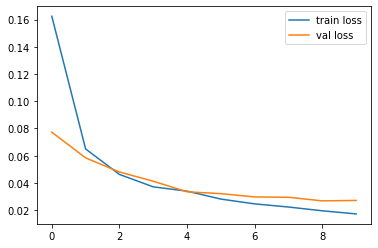

In [19]:
#losses
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

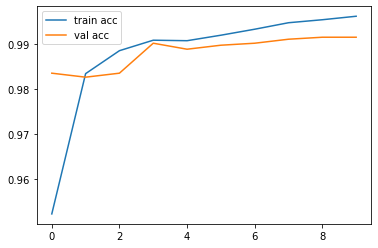

In [20]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

#### Save the model

In [21]:
from keras.models import load_model

model.save('Mask_detector_model.h5')

#### Training set Predictions

In [22]:
train_predictions = model.predict(x = training_set, steps = len(training_set))

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[2199 2307]
 [2324 2182]]


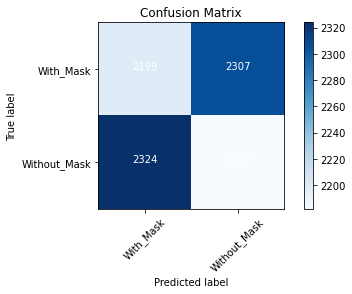

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=training_set.classes, y_pred=np.argmax(train_predictions, axis=-1))
cm_plot_labels = ['With_Mask','Without_Mask']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

#### Testing set predictions

In [25]:
from os import listdir

def loadImagePath(path):
    
    imagesList = listdir(path)
    img_path = []
    for image in imagesList:
        img_path.append(path + image)
    return img_path, imagesList

In [26]:
path = "../input/face-mask-detection/face_mask_detection/test/"

# your images in an array
img_path, imagesList = loadImagePath(path)


In [27]:
img_path[0]

'../input/face-mask-detection/face_mask_detection/test/Image_453.jpg'

In [28]:
imagesList[0]

'Image_453.jpg'

In [29]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

def loadImage(filename):
    
    img = load_img(filename, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    
    return img

In [30]:
predictions = []
for path in img_path:
    
    filepath = path
    img = loadImage(filepath)
    predictions.append(model.predict(img))

In [31]:
len(predictions)

1536

In [32]:
predictions[0]

array([[1., 0.]], dtype=float32)

In [33]:
y_preds = []
for i in range(len(predictions)):
    y_preds.append(np.argmax(predictions[i]))
y_preds[0:5]

[0, 0, 0, 0, 0]

In [34]:
test_set = pd.DataFrame(columns = ['filename', 'label'])
test_set['filename'] = imagesList
test_set['label'] = y_preds

test_set.head()

,filename,label
0,Image_453.jpg,0
1,Image_25.jpg,0
2,Image_812.jpg,0
3,Image_210.jpg,0
4,Image_265.jpg,0


In [35]:
test_set['label'] = test_set['label'].map({1: 'Without_Mask', 0: 'With_Mask'})

In [36]:
test_set.head()

,filename,label
0,Image_453.jpg,With_Mask
1,Image_25.jpg,With_Mask
2,Image_812.jpg,With_Mask
3,Image_210.jpg,With_Mask
4,Image_265.jpg,With_Mask


In [37]:
test = pd.read_csv('../input/face-mask-detection/face_mask_detection/Testing_set_face_mask.csv')

In [38]:
test_final = pd.merge(test, test_set, on='filename',  how='inner')
test_final.head()

,filename,label_x,label_y
0,Image_1.jpg,NaN,Without_Mask
1,Image_2.jpg,NaN,With_Mask
2,Image_3.jpg,NaN,Without_Mask
3,Image_4.jpg,NaN,Without_Mask
4,Image_5.jpg,NaN,With_Mask


In [39]:
test_final.drop('label_x', axis=1, inplace=True)
test_final.rename(columns={'label_y':'label'}, inplace=True)
test_final.head(10)

,filename,label
0,Image_1.jpg,Without_Mask
1,Image_2.jpg,With_Mask
2,Image_3.jpg,Without_Mask
3,Image_4.jpg,Without_Mask
4,Image_5.jpg,With_Mask
5,Image_6.jpg,With_Mask
6,Image_7.jpg,Without_Mask
7,Image_8.jpg,With_Mask
8,Image_9.jpg,Without_Mask
9,Image_10.jpg,Without_Mask


In [40]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cm', 'test', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


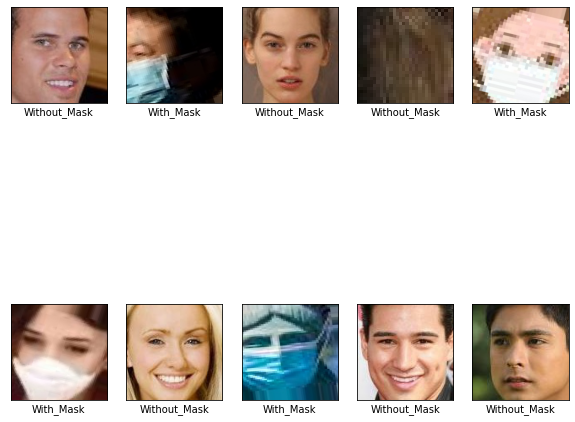

In [41]:
# code to view the images
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid=False
    img = mpimg.imread('../input/face-mask-detection/face_mask_detection/test/' + test_final.loc[i, 'filename'])
    imgplot = plt.imshow(img)
    #plt.show()
    plt.xlabel(test_final.loc[i, 'label'])
plt.show()

In [42]:
test_final.to_csv('Testing_set_face_mask_preds.csv', index=False)